# INTRODUCTION

##Our trading bot will be assisting the user by predicting the future High and Low points(i.e., the date on which the price of the coin will be higher or lower) and also displaying the Hike&Dive percentage(i.e., the percentage increment or decrement of the coin price for the future 30 days) 

In [ ]:
import requests
import pandas as pd

api_key = "2AiEPqP7FjR8DfXwv8PpHVg1IRT"


In [ ]:
res = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr', params = {'a': 'BTC', 'api_key': api_key})

In [ ]:
df = pd.read_json(res.text)

In [ ]:
df

,t,v
0,1279324800,1.000000
1,1279411200,1.174760
2,1279497600,1.318536
3,1279584000,1.090517
4,1279670400,1.065532
...,...,...
4349,1655078400,0.978234
4350,1655164800,0.989107
4351,1655251200,0.993437
4352,1655337600,0.994474


In [ ]:
date_c = pd.to_datetime(df['t'], unit='s')

In [ ]:
df.drop('t',axis=1,inplace=True)
df['t'] = date_c
df[['t','v']]

,t,v
0,2010-07-17,1.000000
1,2010-07-18,1.174760
2,2010-07-19,1.318536
3,2010-07-20,1.090517
4,2010-07-21,1.065532
...,...,...
4349,2022-06-13,0.978234
4350,2022-06-14,0.989107
4351,2022-06-15,0.993437
4352,2022-06-16,0.994474


## LSTM

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use('seaborn')  
  


In [ ]:
df.rename(columns = {'t':'Date', 'v':'Close'}, inplace = True)

In [ ]:
df[['Date', 'Close']]

,Date,Close
0,2010-07-17,1.000000
1,2010-07-18,1.174760
2,2010-07-19,1.318536
3,2010-07-20,1.090517
4,2010-07-21,1.065532
...,...,...
4349,2022-06-13,0.978234
4350,2022-06-14,0.989107
4351,2022-06-15,0.993437
4352,2022-06-16,0.994474


In [ ]:
df1 = df.reset_index()['Close']

In [ ]:
df1.shape

(4354,)

Text(0, 0.5, 'Price')

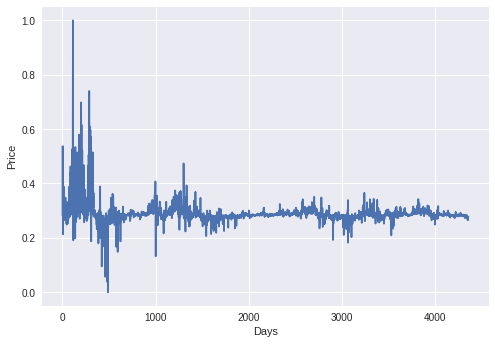

In [ ]:
plt.plot(df1)
plt.xlabel("Days")
plt.ylabel("Price")

In [ ]:
# transforming the Close value between 0 and 1 because LSTM model is sensitive to scale of data
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [ ]:
df1. shape

(4354, 1)

In [ ]:
##Splitting dataset into train and test split
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(3483, 871)

In [ ]:
train_data

array([[0.28229686],
       [0.42224827],
       [0.53738715],
       ...,
       [0.28530149],
       [0.28597639],
       [0.28965612]])

## Data preprocessing

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(3382, 100)
(3382,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(770, 100)
(770,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=500,batch_size=64,verbose=1)

Epoch 1/500
53/53 [==============================] - 11s 36ms/step - loss: 0.0054 - val_loss: 9.0538e-05
Epoch 2/500
53/53 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 4.9585e-05
Epoch 3/500
53/53 [==============================] - 1s 15ms/step - loss: 0.0011 - val_loss: 4.8047e-05
Epoch 4/500
53/53 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 6.6078e-05
Epoch 5/500
53/53 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 2.1288e-04
Epoch 6/500
53/53 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 4.9754e-05
Epoch 7/500
53/53 [==============================] - 1s 16ms/step - loss: 0.0010 - val_loss: 6.5866e-05
Epoch 8/500
53/53 [==============================] - 1s 16ms/step - loss: 0.0010 - val_loss: 4.7102e-05
Epoch 9/500
53/53 [==============================] - 1s 16ms/step - loss: 0.0010 - val_loss: 3.1494e-04
Epoch 10/500
53/53 [==============================] - 1s 16ms/s

In [ ]:
import tensorflow as tf


In [ ]:
tf.__version__

'2.8.2'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

Why you have choosen RMSE?????

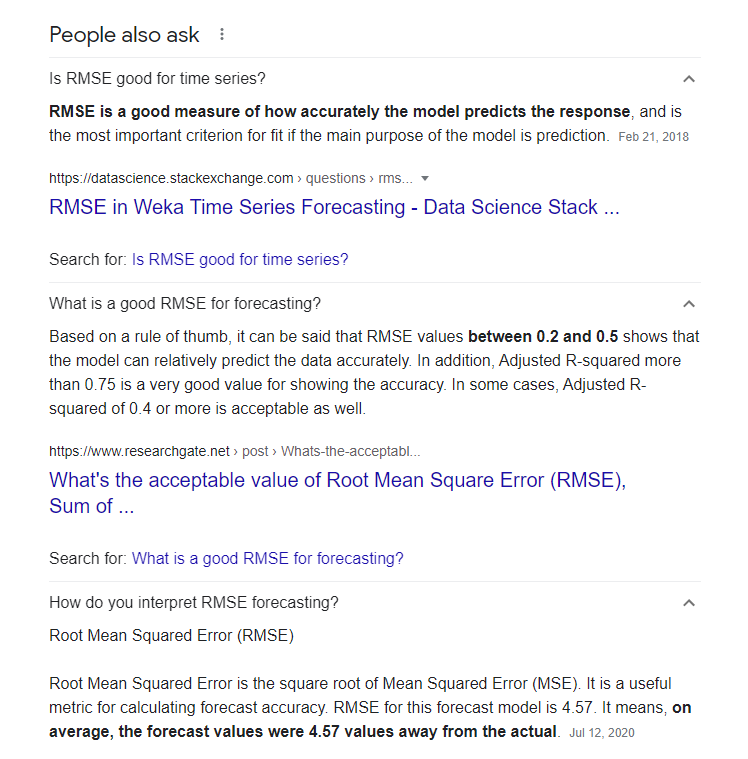

In [ ]:
### Calculate RMSE performance metrics
#Train data
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.7233273754638027

## This is the RMSE score for the test data(the data on which model is not trained)

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.7223117486142641

### Which according to the snippet attached is good

In [ ]:
#Now we are feeding the model the crypto price value for the last 100 days in order to predict the future 30 days price from now.

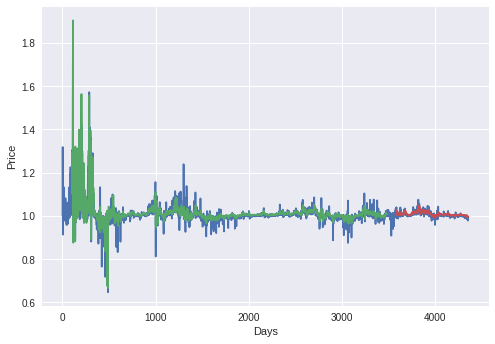

<Figure size 7200x720 with 0 Axes>

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.xlabel("Days")
plt.ylabel("Price")
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.figure(figsize=(100, 10))

plt.show()

In [ ]:
len(test_data)

871

In [ ]:
x_input=test_data[771:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
#temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.28024784]
101
1 day input [0.28421723 0.28257244 0.28186948 0.28228081 0.28145953 0.28442923
 0.28129653 0.28338319 0.28319233 0.28238758 0.28230834 0.28490103
 0.28304201 0.28492827 0.29230026 0.28279289 0.28432945 0.28788856
 0.28576935 0.28370617 0.28203103 0.28416835 0.28261202 0.28308069
 0.2831889  0.28265604 0.28084726 0.28141347 0.28173587 0.28186456
 0.28228998 0.27988455 0.28394804 0.28261834 0.283592   0.28237584
 0.28195688 0.28207711 0.28185403 0.28294139 0.28286632 0.28575105
 0.28061476 0.2820297  0.28198529 0.28155142 0.2809364  0.28207163
 0.28226478 0.28086096 0.28142971 0.28098499 0.28026901 0.28081289
 0.28334732 0.28084019 0.28097658 0.28112525 0.28003232 0.27454286
 0.27877987 0.27325598 0.27803562 0.27966099 0.28547246 0.28185847
 0.27966325 0.27990801 0.27686666 0.27694072 0.27576738 0.28021035
 0.28208831 0.27713261 0.2797305  0.28058165 0.27701977 0.27397083
 0.28147867 0.28196861 0.28402012 0.28420018 0.27781136 0.26988846
 0.27697776 0.2737381  0.27999472

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

4354

Text(0, 0.5, 'Price')

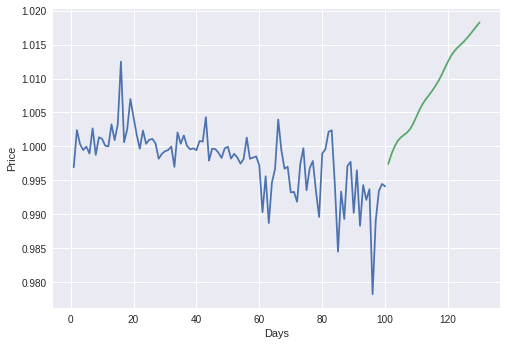

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[4254:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.xlabel("Days")
plt.ylabel("Price")

In [ ]:
a = scaler.inverse_transform(lst_output)

In [ ]:
lst_output = a.tolist()


In [ ]:
lst_output

[[0.9974413438604539],
 [0.9988819242891877],
 [0.9999946061346724],
 [1.0008276196277432],
 [1.0013385028136297],
 [1.0017013459854238],
 [1.002064449660008],
 [1.0026090121351736],
 [1.0034518503048964],
 [1.0044688159823958],
 [1.005470672498075],
 [1.0063196883053893],
 [1.0070030987676282],
 [1.0076095864774466],
 [1.0082418639634758],
 [1.0089346153114707],
 [1.009690668837437],
 [1.0105867240056894],
 [1.0115771556132926],
 [1.0125465237095896],
 [1.0133898828848922],
 [1.0140514111127705],
 [1.0145630013776583],
 [1.0149958453705956],
 [1.0154459569770418],
 [1.0159539002028695],
 [1.0165136834839084],
 [1.0170958327902033],
 [1.0176835642991415],
 [1.0182690629270224]]

In [ ]:
my_list= sum(lst_output, [])

In [ ]:
my_list

[0.9974413438604539,
 0.9988819242891877,
 0.9999946061346724,
 1.0008276196277432,
 1.0013385028136297,
 1.0017013459854238,
 1.002064449660008,
 1.0026090121351736,
 1.0034518503048964,
 1.0044688159823958,
 1.005470672498075,
 1.0063196883053893,
 1.0070030987676282,
 1.0076095864774466,
 1.0082418639634758,
 1.0089346153114707,
 1.009690668837437,
 1.0105867240056894,
 1.0115771556132926,
 1.0125465237095896,
 1.0133898828848922,
 1.0140514111127705,
 1.0145630013776583,
 1.0149958453705956,
 1.0154459569770418,
 1.0159539002028695,
 1.0165136834839084,
 1.0170958327902033,
 1.0176835642991415,
 1.0182690629270224]

## Bot will be displaying this as an output

## For finding out the highest and lowest point

In [ ]:
import datetime
from datetime import date 
from datetime import timedelta 

gDate = date.today()
max_value = max(my_list) 
max_value_index = my_list.index(max_value)
Highest_point = gDate + timedelta(max_value_index) 
print("The date on which the price will be higher: ", Highest_point)

min_value = min(my_list) # returns 1
min_value_index = my_list.index(min_value)
Lowest_point = gDate + timedelta(min_value_index) 
print("The date on which the price will be lower: ", Lowest_point)

The date on which the price will be higher:  2022-07-17
The date on which the price will be lower:  2022-06-18


In [ ]:
def get_variation(values: pd.Series) -> np.float64:
    base = values.iloc[0]
    current = values.iloc[-1]

    return (current - base) / base if base else 0

In [ ]:
y = pd.Series(my_list)

In [ ]:
y = y.to_frame(name='Hike&Dive-Percentage')

In [ ]:
variations = y['Hike&Dive-Percentage'].expanding(min_periods=2).apply(get_variation)
variations

0          NaN
1     0.001444
2     0.002560
3     0.003395
4     0.003907
5     0.004271
6     0.004635
7     0.005181
8     0.006026
9     0.007045
10    0.008050
11    0.008901
12    0.009586
13    0.010194
14    0.010828
15    0.011523
16    0.012281
17    0.013179
18    0.014172
19    0.015144
20    0.015989
21    0.016653
22    0.017166
23    0.017600
24    0.018051
25    0.018560
26    0.019121
27    0.019705
28    0.020294
29    0.020881
Name: Hike&Dive-Percentage, dtype: float64

In [ ]:
y = pd.DataFrame(variations)

In [ ]:
from datetime import timedelta
mydate = []
for i in range(0,30):
  dt = date.today()
  td = timedelta(days=i)

  my_date = dt + td
  mydate.append(my_date)

In [ ]:
type(mydate)

list

In [ ]:
z = pd.Series(mydate)

In [ ]:
z = z.to_frame(name='Date')

hike_percentage = pd.concat([y, z], axis=1, join='inner')


## The Bot will also be displaying this as an output

## Calculating the Hike&Dive Percentage based on current date

In [ ]:
hike_percentage[['Date', 'Hike&Dive-Percentage']]

,Date,Hike&Dive-Percentage
0,2022-06-18,NaN
1,2022-06-19,0.001444
2,2022-06-20,0.002560
3,2022-06-21,0.003395
4,2022-06-22,0.003907
5,2022-06-23,0.004271
6,2022-06-24,0.004635
7,2022-06-25,0.005181
8,2022-06-26,0.006026
9,2022-06-27,0.007045


In [ ]:
###############################################    END        #####################################################################################

Text(0, 0.5, 'Price')

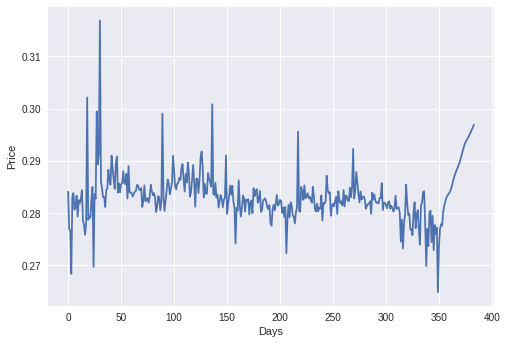

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[4000:])
plt.xlabel("Days")
plt.ylabel("Price")

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

Text(0, 0.5, 'Price')

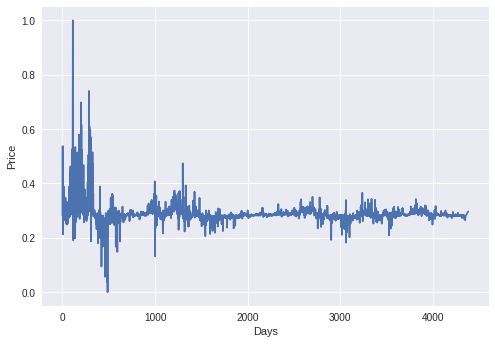

In [ ]:
plt.plot(df3)
plt.xlabel("Days")
plt.ylabel("Price")

In [ ]:
df3

[[1.0],
 [1.17475978713072],
 [1.3185357308409602],
 [1.09051712218598],
 [1.06553209757381],
 [0.9135416911114991],
 [1.04230693742033],
 [1.00903398814194],
 [1.01956210587547],
 [1.02816825135668],
 [1.04259648486522],
 [1.03374595826373],
 [1.03376888026791],
 [1.13308705312035],
 [1.03068090642885],
 [1.0050036138177],
 [1.01170340921075],
 [1.00723095943519],
 [1.0080775271006],
 [0.9938714437608521],
 [1.06250700968908],
 [1.02044916741683],
 [1.03135067485697],
 [1.07419550431199],
 [1.05241811267567],
 [1.04063464139604],
 [0.9781211093019081],
 [1.07963728876467],
 [1.01214047608759],
 [1.04578535241414],
 [1.01688997456682],
 [1.01906869091328],
 [1.08205406001034],
 [1.01684812816284],
 [0.99703228496905],
 [1.03123711890331],
 [1.04595922555181],
 [1.012136654005],
 [1.01556525947127],
 [1.00947899319812],
 [1.0028460485604],
 [1.02381934430593],
 [1.00425652245537],
 [0.960926696237937],
 [0.9753083161994152],
 [1.01717756329856],
 [0.9584061700866141],
 [0.98264800331355